In [414]:
import chess.pgn
import decimal
import functools
import io
import json
import pandas as pd
import seaborn as sns
import statistics


In [415]:
with open(f"games/cleaned_games.json", "r") as f:
    games = json.loads(f.read())


In [435]:
def get_chess_results(game, print_moves=True):
    headers = game.headers
    hikaru_color = "White" if headers["White"] == "Hikaru" else "Black"
    white_clock, black_clock = 180, 180
    white_time_taken, black_time_taken = 0, 0
    delta_times = []
    for i, move in enumerate(game.mainline()):
        if i > 1 and i % 2 == 0:
            delta_time = decimal.Decimal(f"{black_time_taken - white_time_taken : .2f}")
            delta_times.append(delta_time)
    
        if not move.turn(): # White's turn
            white_time_taken += white_clock - move.clock()
            white_clock = move.clock()
        else:
            black_time_taken += black_clock - move.clock()
            black_clock = move.clock()

        if print_moves:
            print(f"Move: {((i + 1)//2 - (i % 2) + 1)} {'Hikaru' if (hikaru_color == 'White' and not move.turn()) or (hikaru_color != 'White' and move.turn())  else 'Opponent' : >9} - {move.move}: {move.clock()}")
    
    game_result = headers["Result"]
    if (hikaru_color == "White" and game_result == "1-0") or (hikaru_color != "White" and game_result == "0-1"):
        result = "Hikaru Win"
    elif game_result == "1/2-1/2":
        result = "Draw"
    else:
        result = "Hikaru Lose"
    return {"times": delta_times, "result": result, "color": hikaru_color, "link": headers["Link"]}

In [428]:
results = []
for i, chess_game in enumerate(games):
    chess_obj = chess.pgn.read_game(io.StringIO(chess_game["pgn"]))
    result = get_chess_results(chess_obj, print_moves=False)
    if result["times"]:
        # This removes games that have less than 2 initial moves (one move and resign)
        results.append(result)
print(len(results))


5064


In [464]:
avg_times = statistics.mean(map(lambda x: statistics.mean(x["times"]), results))

wins = filter(lambda x: x["result"] == "Hikaru Win", results)
draws = filter(lambda x: x["result"] == "Draw", results)
losses = filter(lambda x: x["result"] == "Hikaru Lose", results)

get_times = lambda x: x["times"]
avg_time_wins = list(map(get_times, wins))
avg_time_draws = list(map(get_times, draws))
avg_time_losses = list(map(get_times, losses))

times = list(map(lambda x: x["times"], results))

In [492]:
get_averages = lambda x: statistics.mean(x)
print(f" Average Time: {avg_times : .3f}\n Average Time for Wins: {statistics.mean(map(get_averages, avg_time_wins)) : .3f}\n Average Time for Draws: {statistics.mean(map(get_averages, avg_time_draws)) : .3f}\n Average Time for Losses: {statistics.mean(map(get_averages, avg_time_losses)) : .3f}")


 Average Time:  1.444
 Average Time for Wins:  1.519
 Average Time for Draws:  1.605
 Average Time for Losses:  0.798


In [493]:
avg_times_df = pd.DataFrame(times)
avg_time_wins_df = pd.DataFrame(avg_time_wins)
avg_time_draws_df = pd.DataFrame(avg_time_draws)
avg_time_losses_df = pd.DataFrame(avg_time_losses)


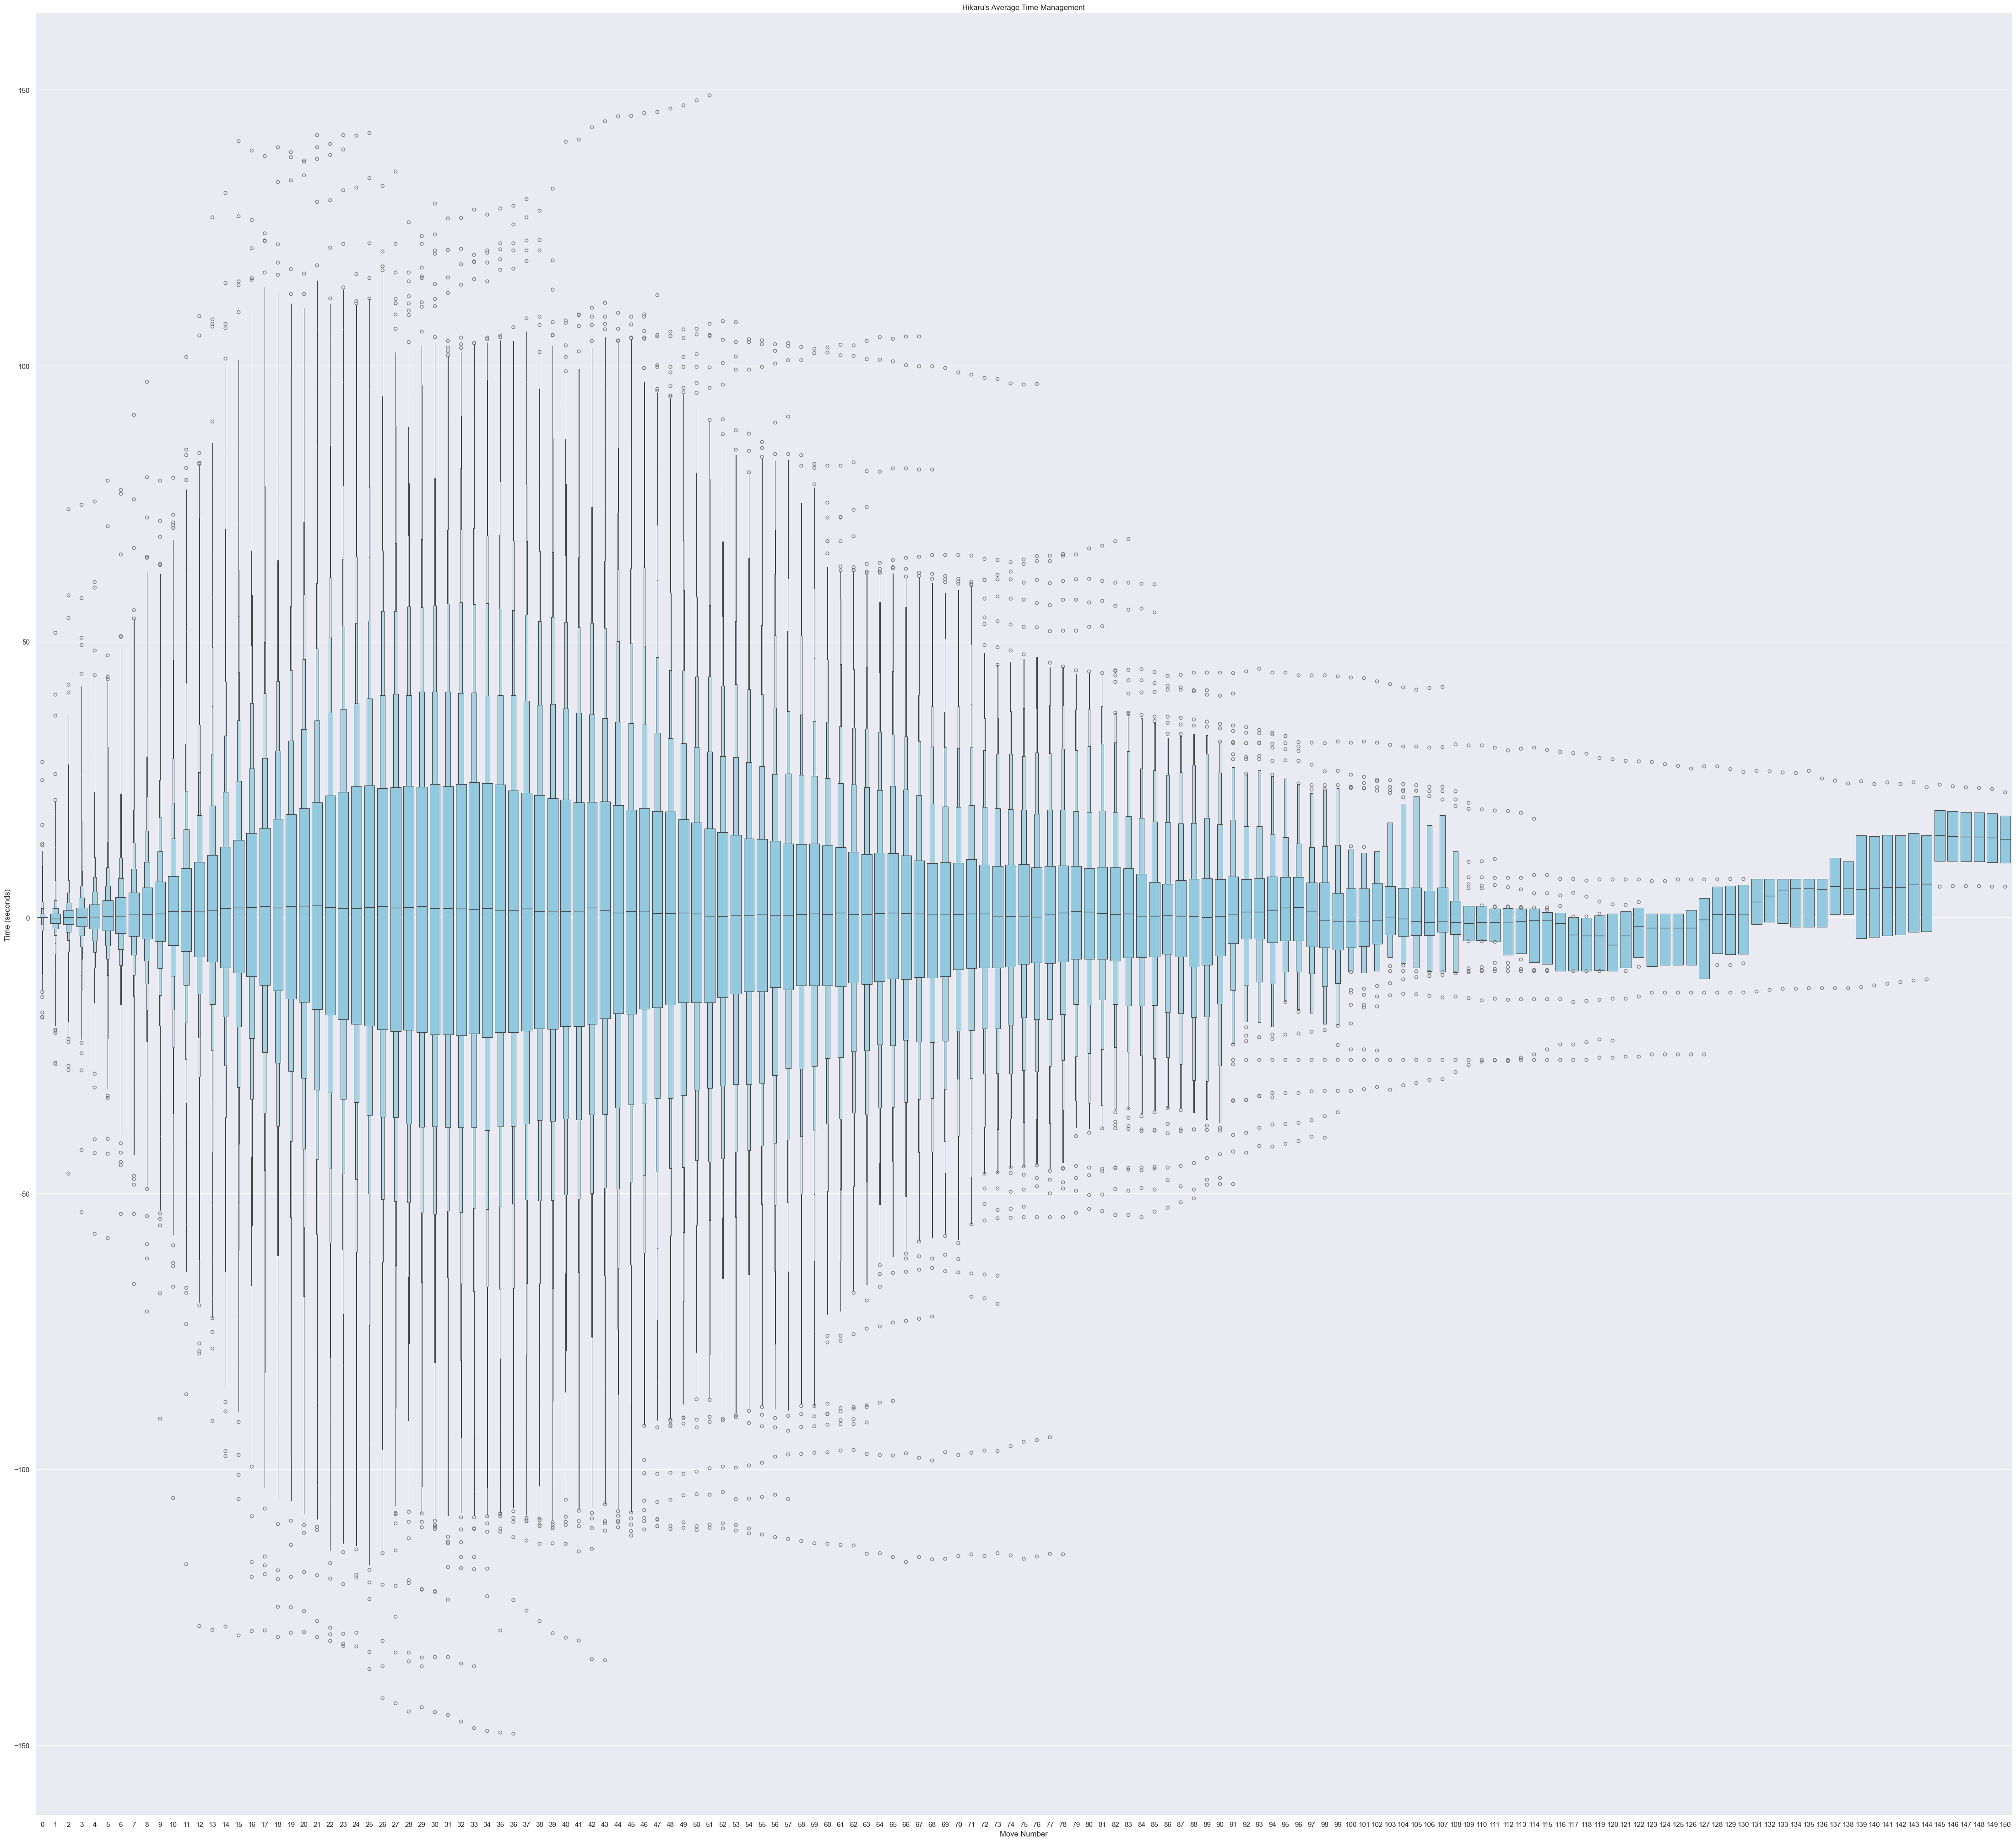

In [505]:
ax1 = sns.catplot(data=avg_times_df, kind="boxen", showfliers=True, height=40, aspect=11/10, color="skyblue")
ax1.set(xlabel='Move Number', ylabel='Time (seconds)', title="Hikaru's Average Time Management")

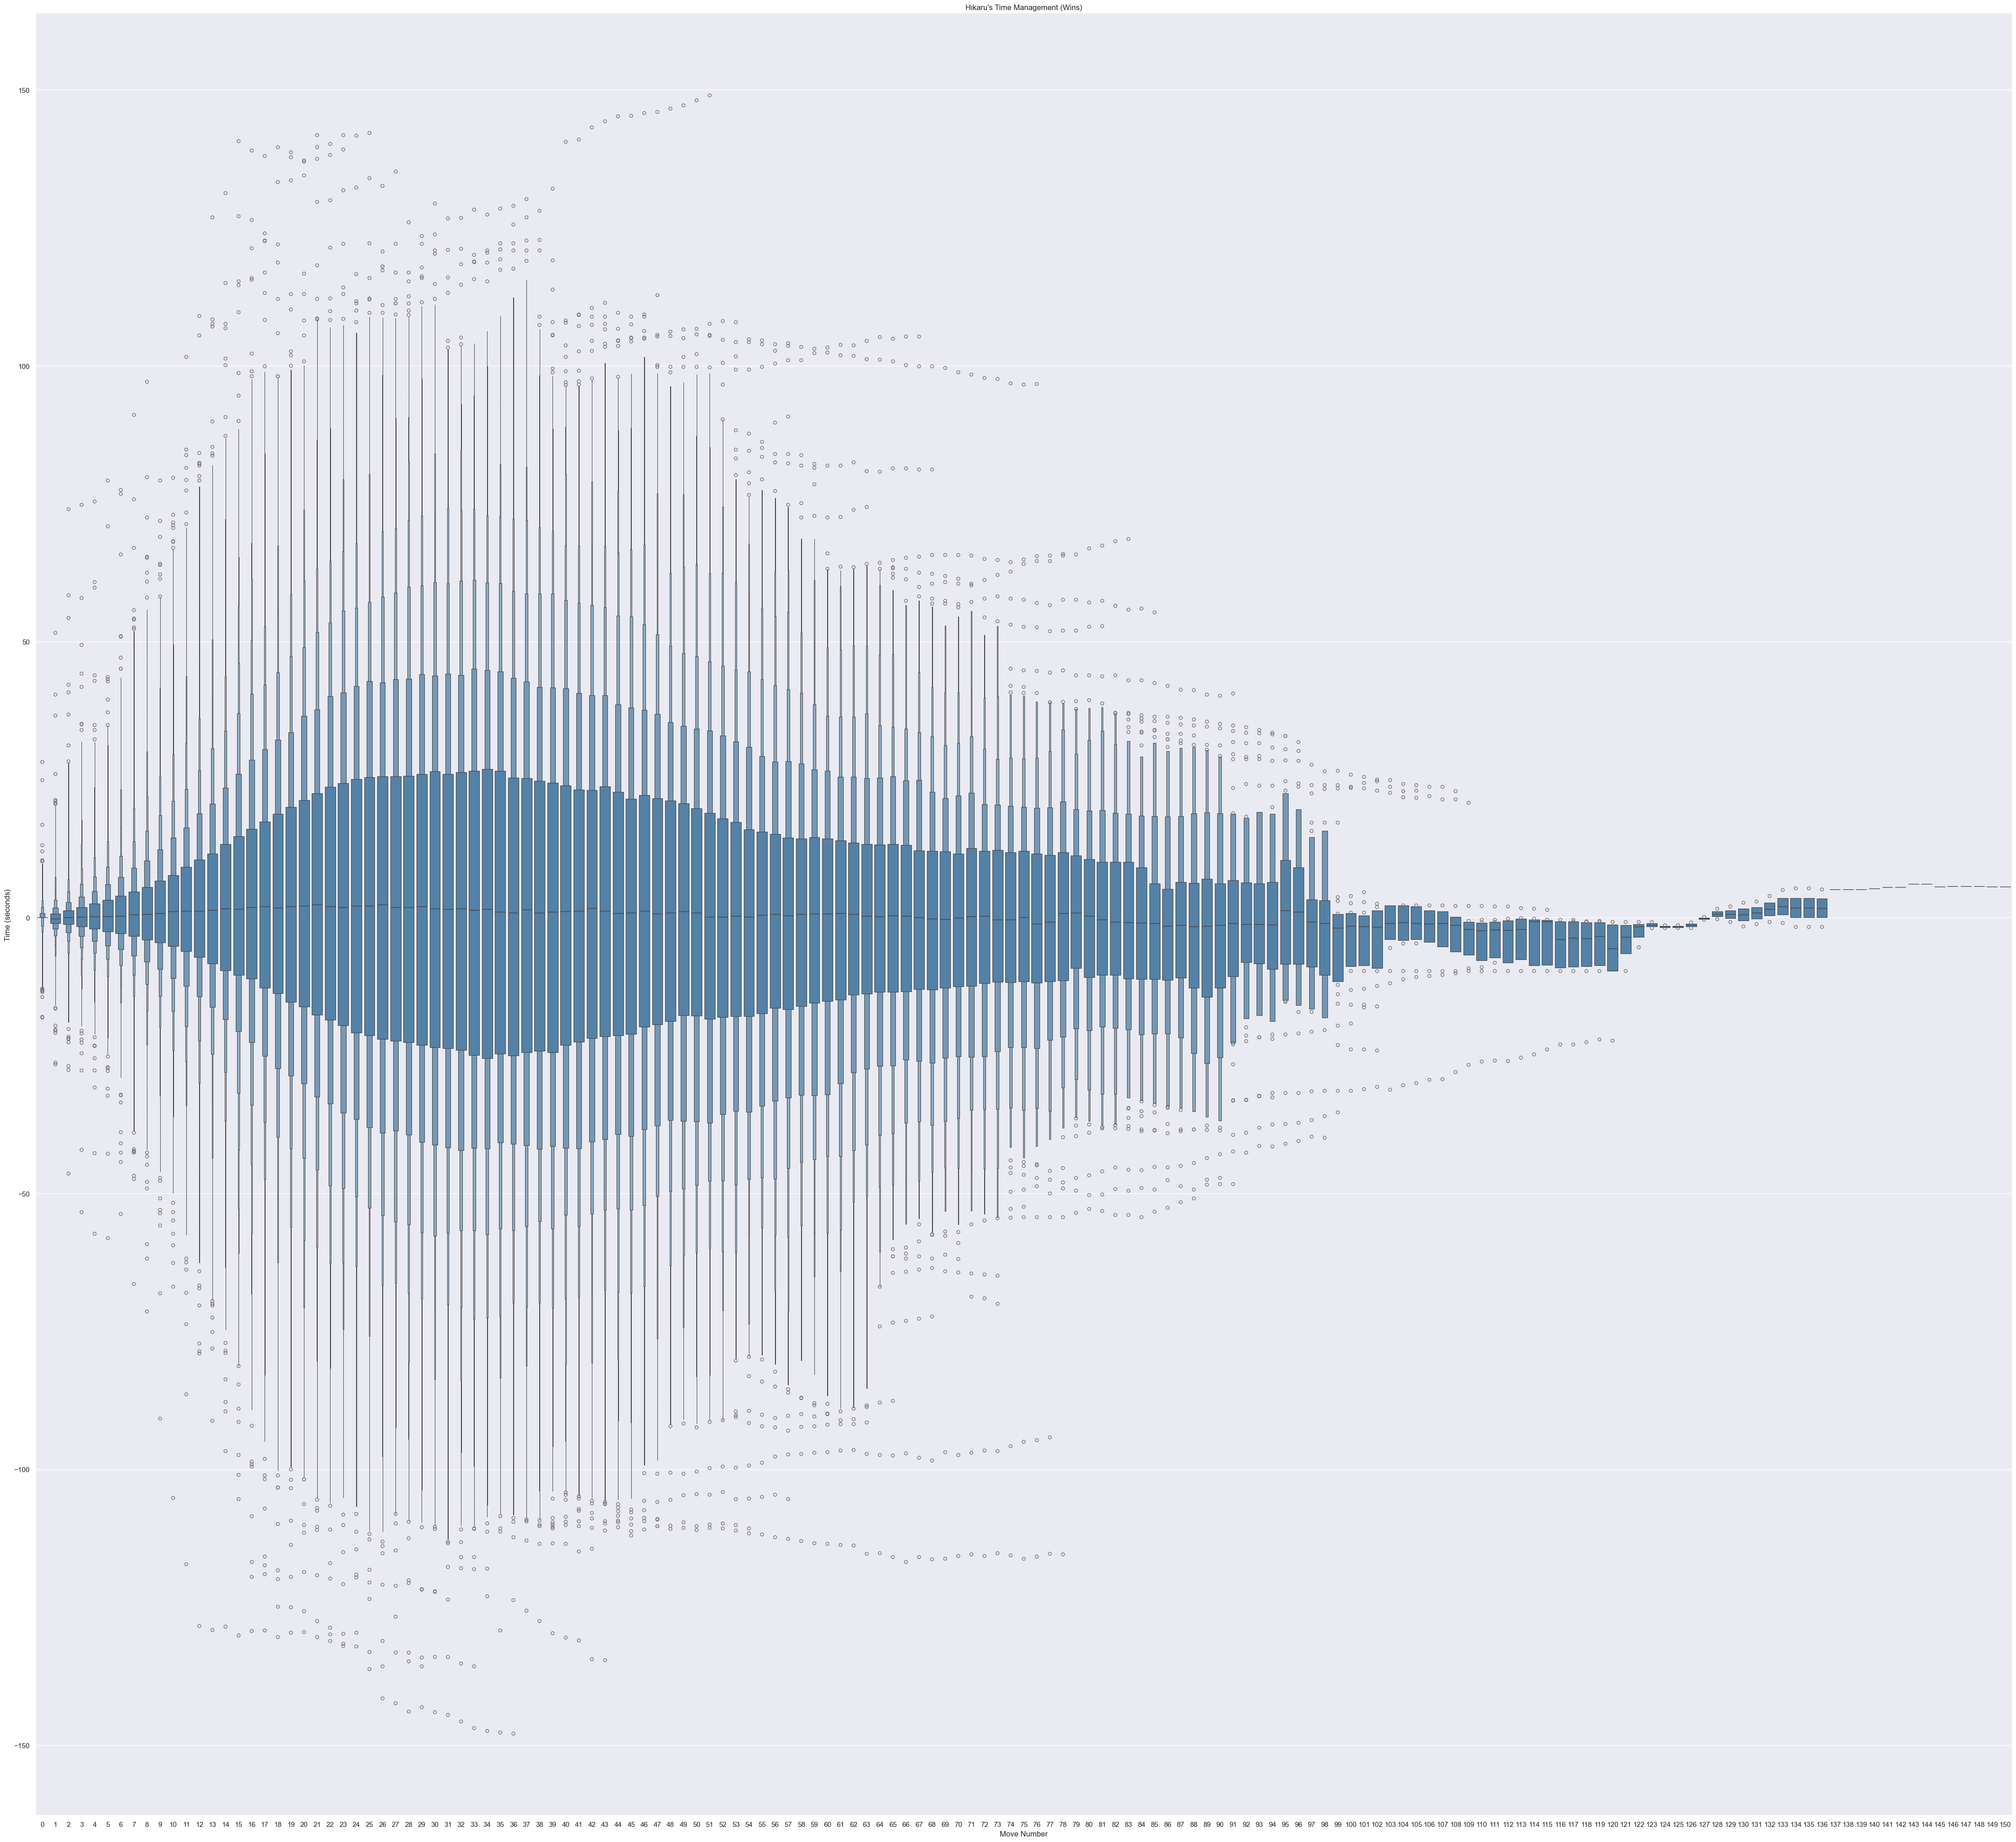

In [506]:
ax2 = sns.catplot(data=avg_time_wins_df, kind="boxen", showfliers=True, height=40, aspect=11/10, color="steelblue")
ax2.set(xlabel='Move Number', ylabel='Time (seconds)', title="Hikaru's Time Management (Wins)")

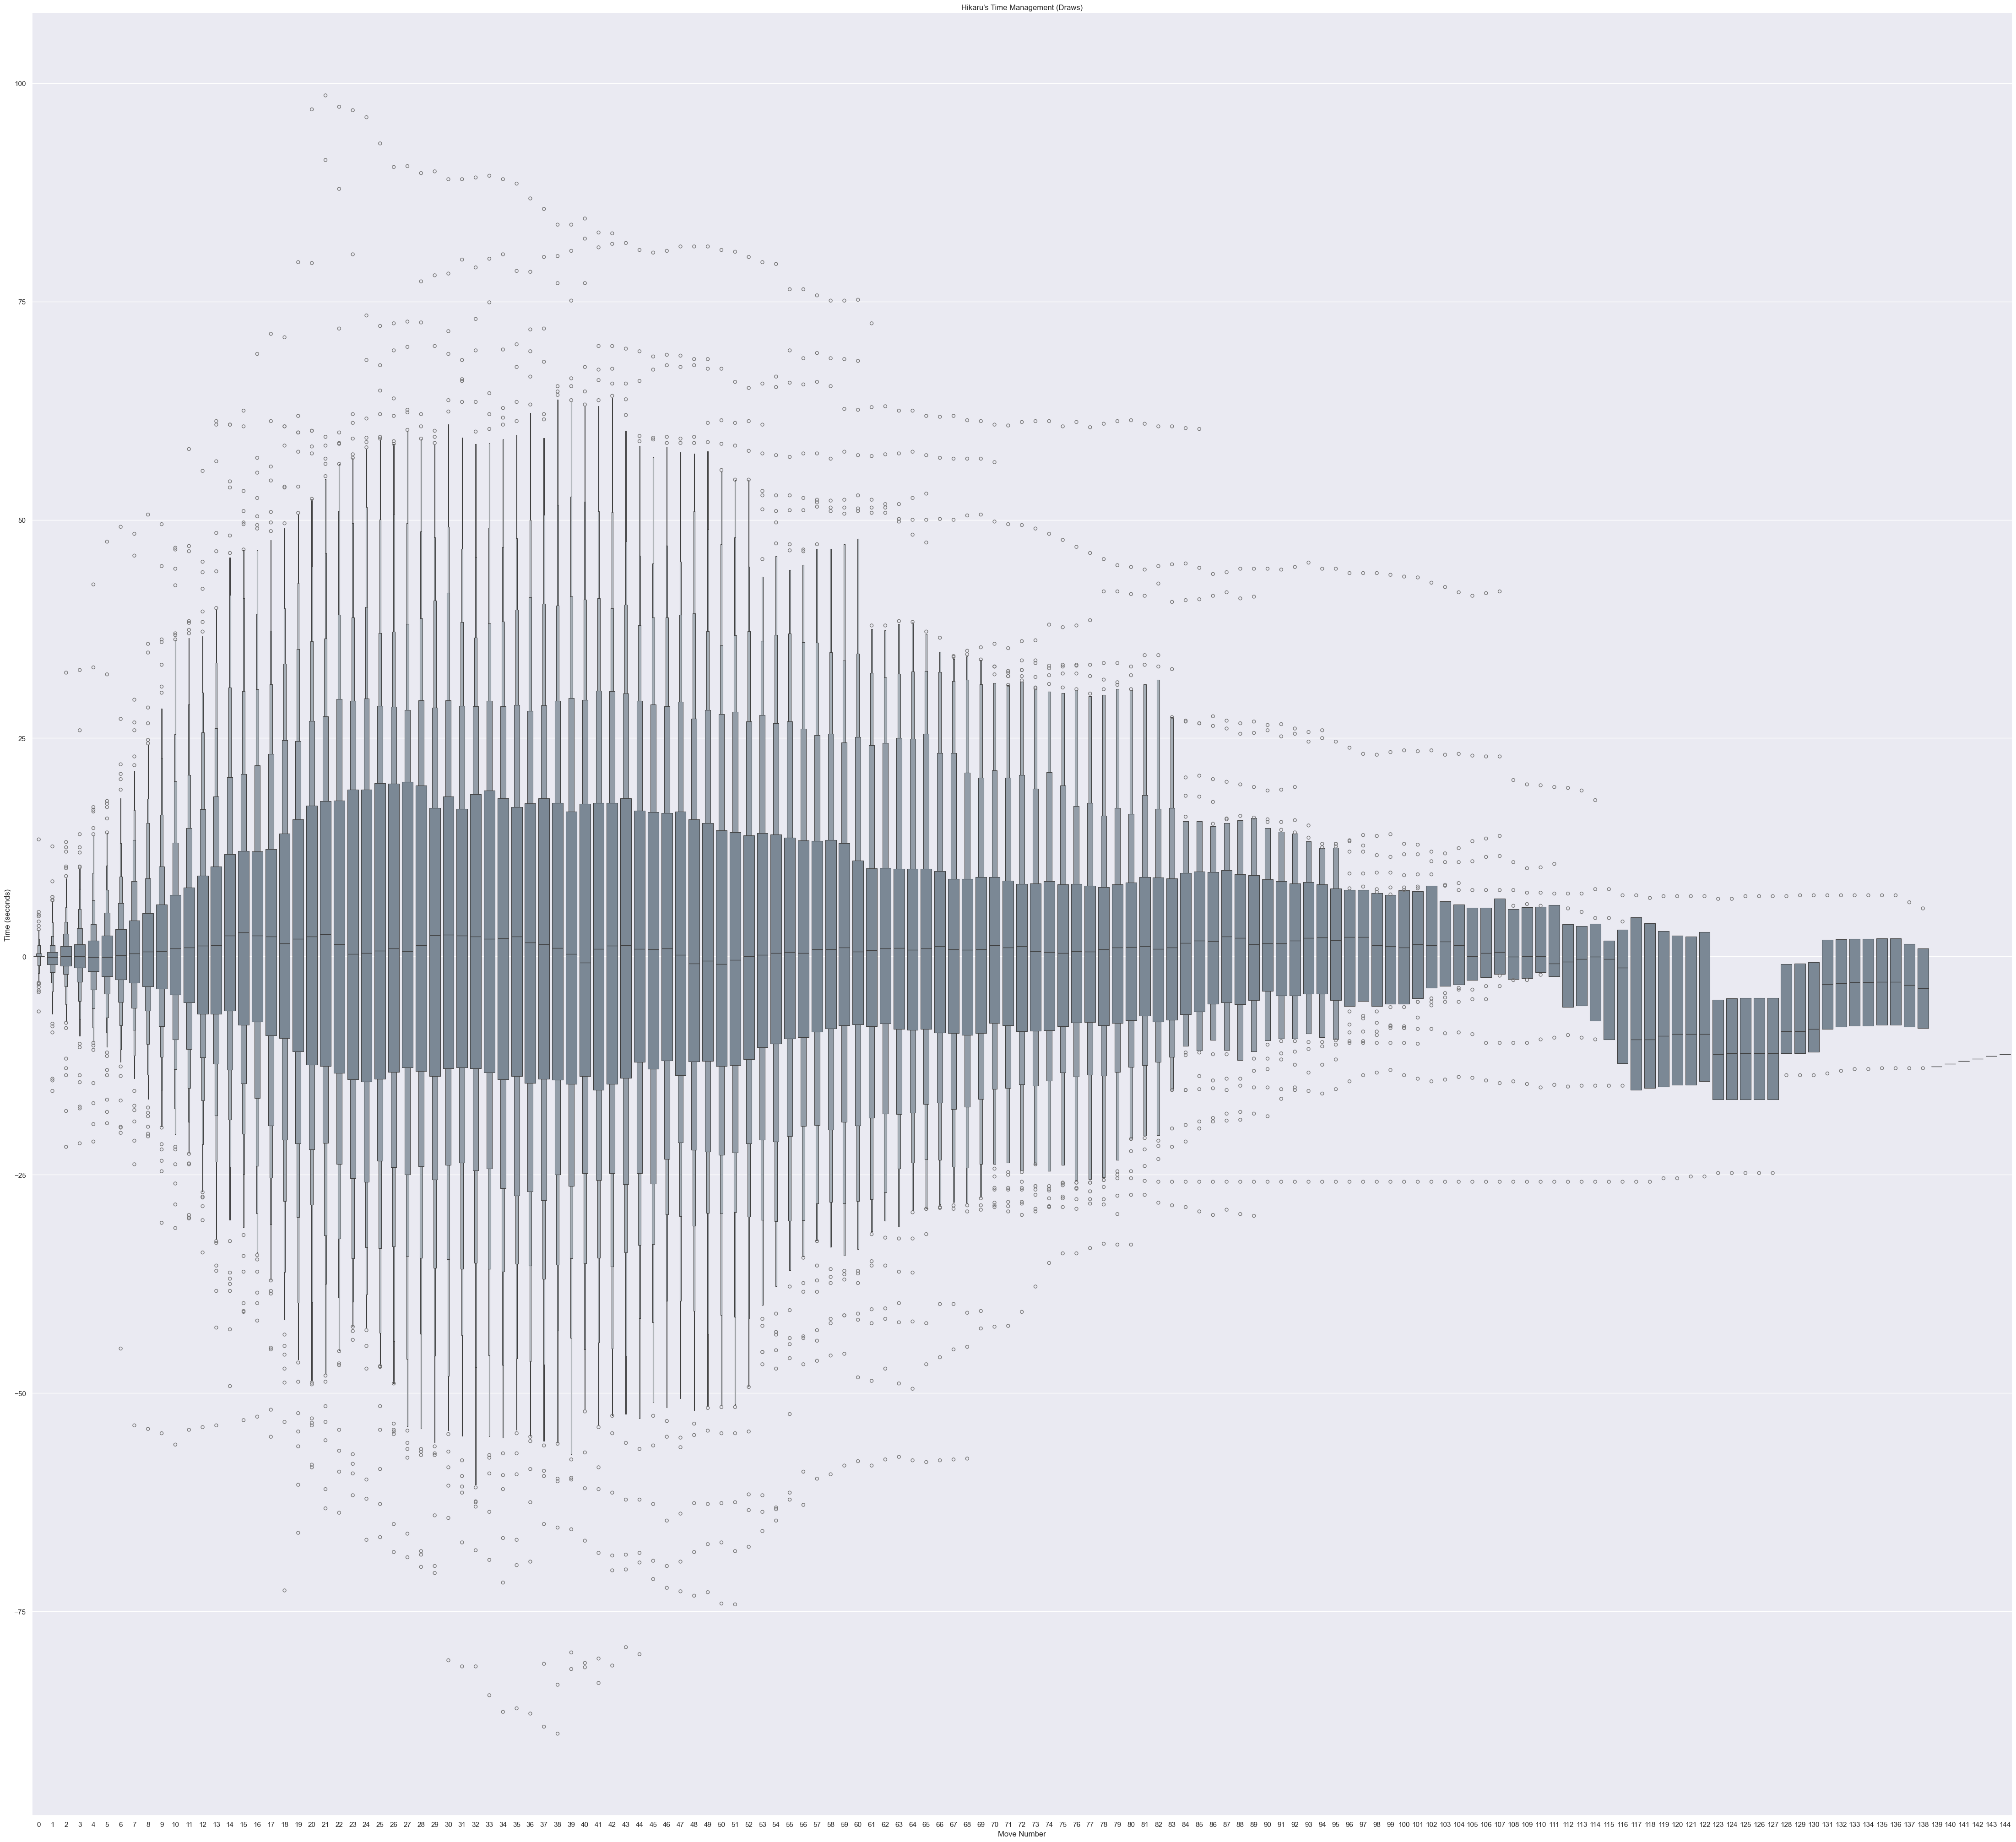

In [507]:
ax3 = sns.catplot(data=avg_time_draws_df, kind="boxen", showfliers=True, height=40, aspect=11/10, color="lightslategray")
ax3.set(xlabel='Move Number', ylabel='Time (seconds)', title="Hikaru's Time Management (Draws)")

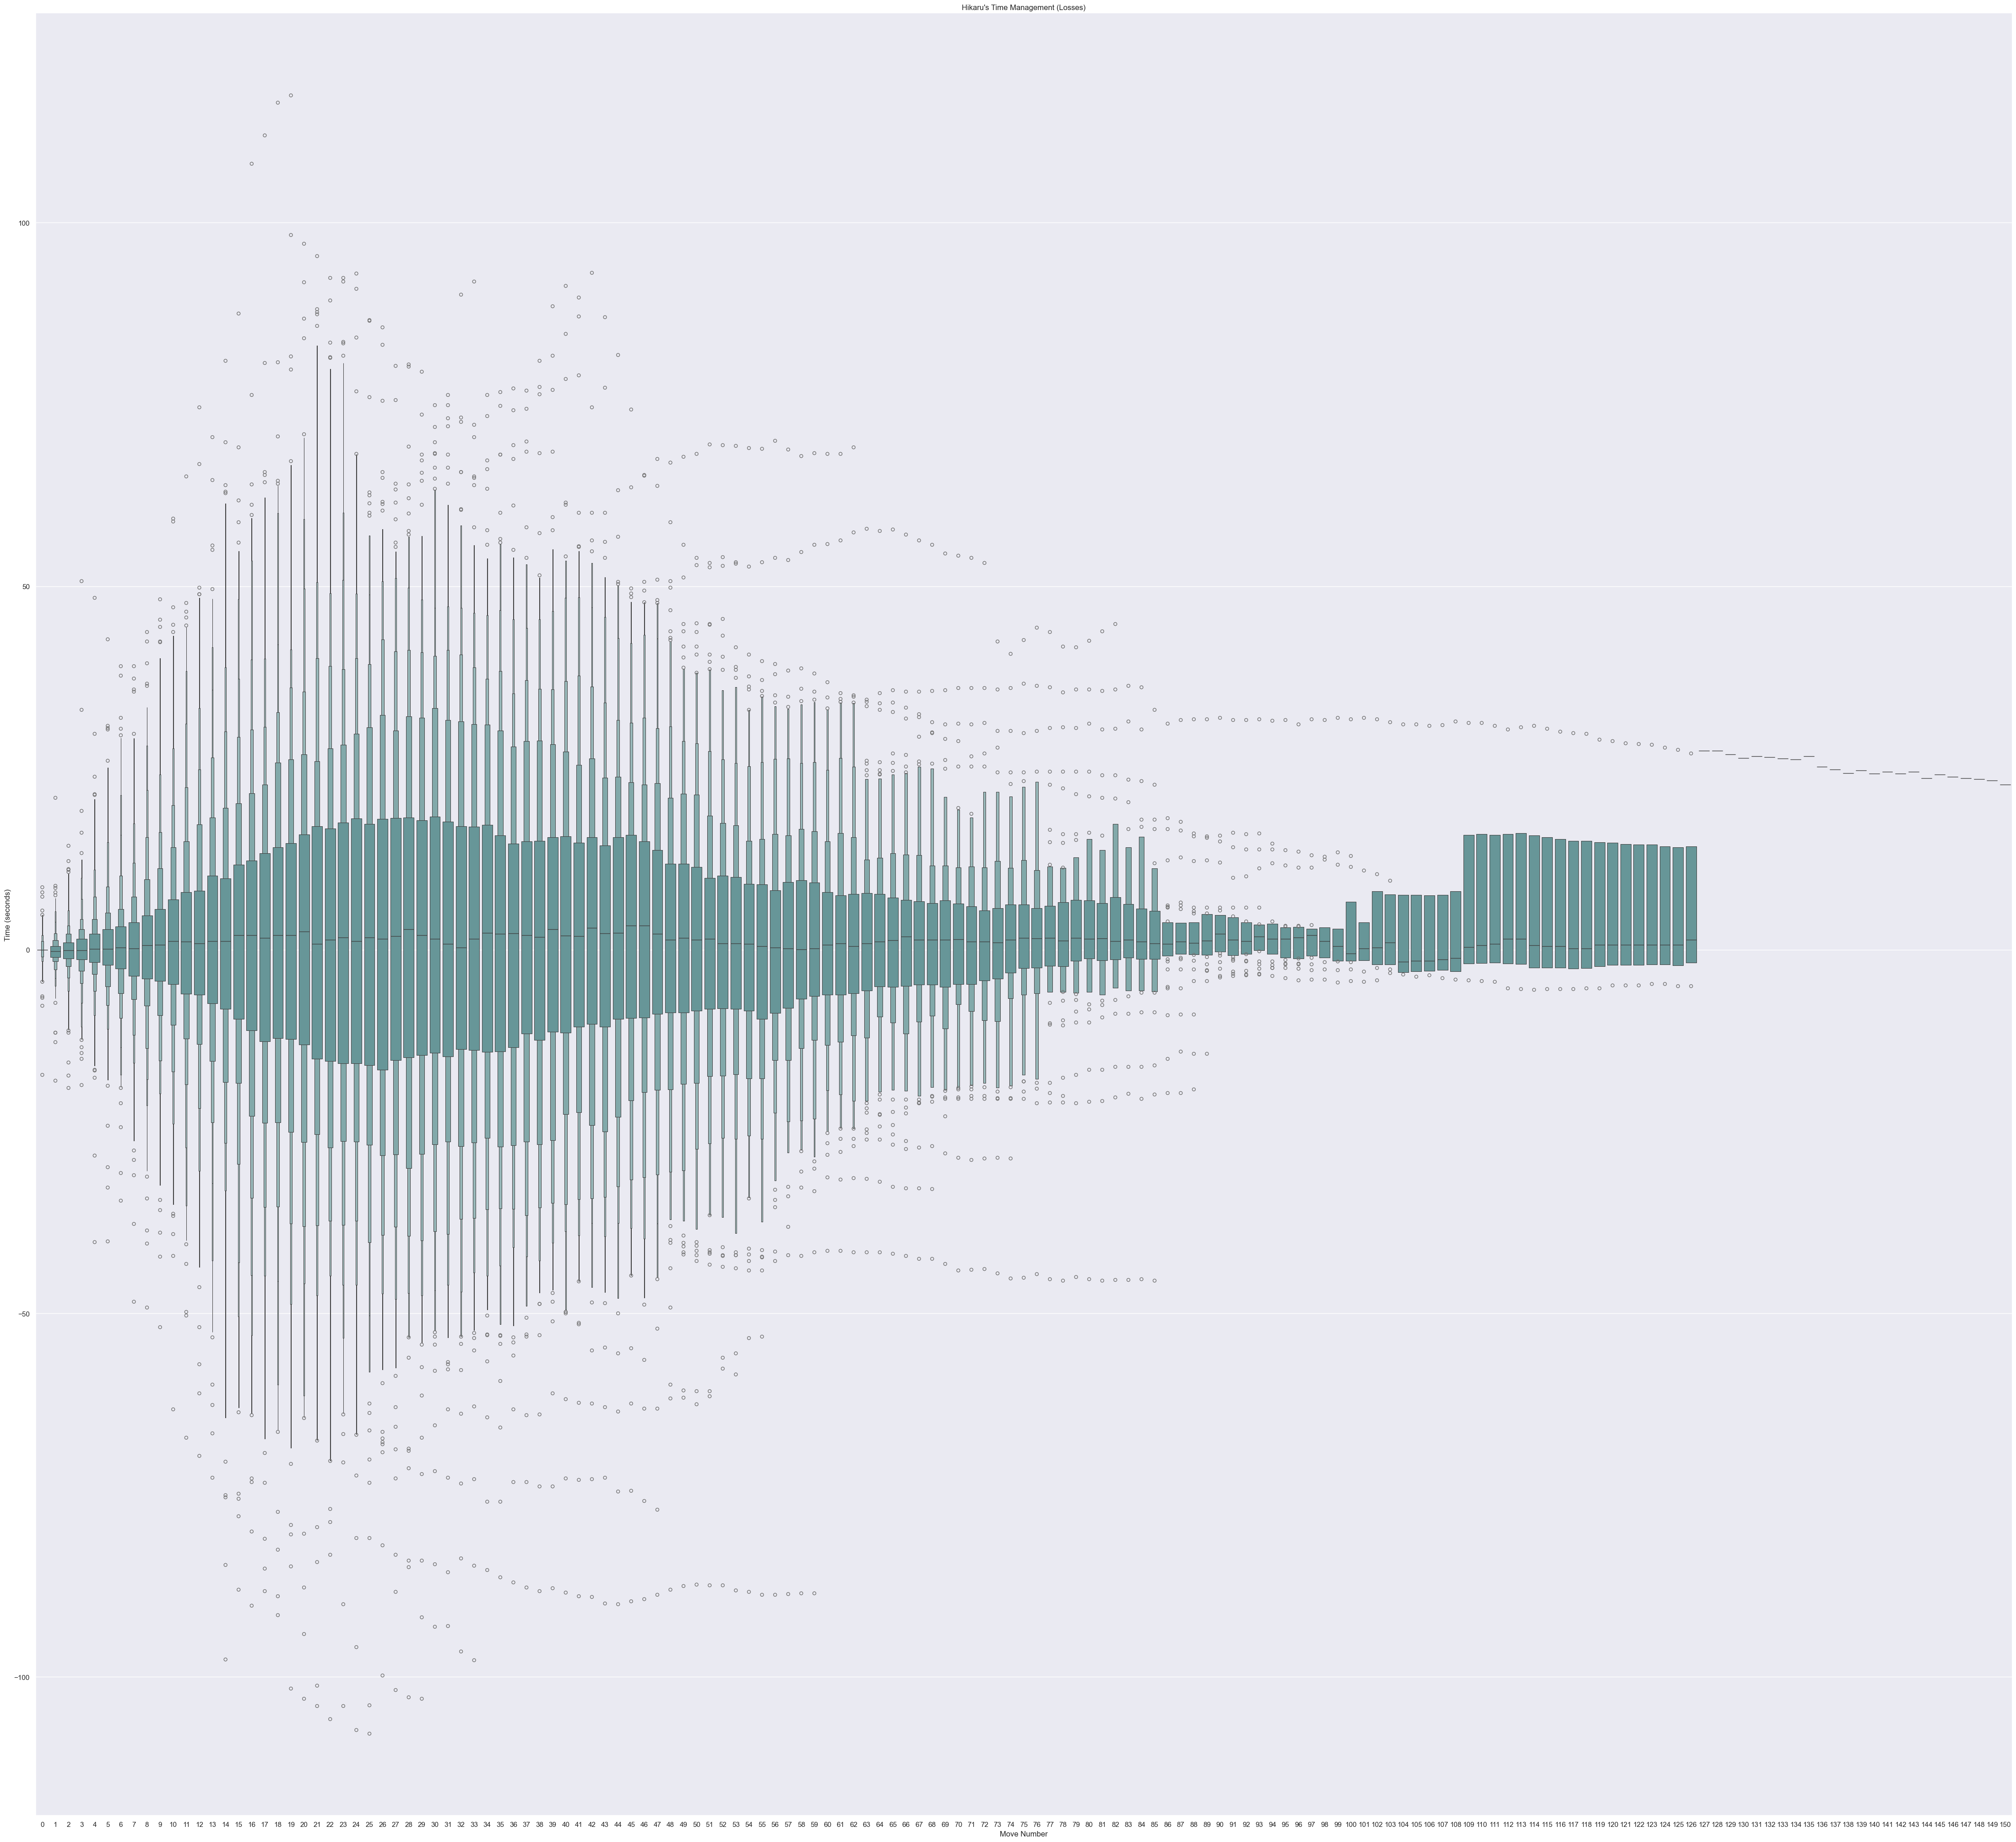

In [508]:
ax4 = sns.catplot(data=avg_time_losses_df, kind="boxen", showfliers=True, height=40, aspect=11/10, color="cadetblue")
ax4.set(xlabel='Move Number', ylabel='Time (seconds)', title="Hikaru's Time Management (Losses)")

In [509]:
ax1.savefig("avg_time.png")
ax2.savefig("avg_time_wins.png")
ax3.savefig("avg_time_draws.png")
ax4.savefig("avg_time_losses.png")